In [72]:
import pandas as pd
import time
from google.colab import userdata
import random
from requests.exceptions import HTTPError
from google.colab import userdata, drive
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
gemini_api_key = userdata.get('GOOGLE_API_KEY')

In [73]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
file_path = '/content/drive/MyDrive/rendered_religion_sentences (24).csv'
df = pd.read_csv(file_path)

In [75]:
import requests

url = "https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent"
response = requests.post(url, json={
  "contents":[
      {
        "parts":[{"text": "Say 'hello I am gemini' and nothing else"}]
      }
    ]
  },
  params={"key": gemini_api_key}
)
print(response.text)

{
  "candidates": [
    {
      "content": {
        "parts": [
          {
            "text": "Hello I am Gemini\n"
          }
        ],
        "role": "model"
      },
      "finishReason": "STOP",
      "avgLogprobs": -0.047117152810096742
    }
  ],
  "usageMetadata": {
    "promptTokenCount": 11,
    "candidatesTokenCount": 5,
    "totalTokenCount": 16
  },
  "modelVersion": "gemini-1.5-flash-latest"
}



In [76]:
response.raise_for_status()  # Check if the Response was Ok (status code 2xx)
response_dict = response.json()  # Convert the JSON-formatted string to a dictionary
# print(response_dict)

completion = response_dict["candidates"][0]["content"]["parts"][0]["text"]  # Get just the completion from the response
print(completion)

Hello I am Gemini



In [77]:
def simple_completion(input_messgage: str) -> str:
  url = "https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent"
  response = requests.post(url, json={
    "contents":[
        {
          "parts":[{"text": input_messgage}]
        }
      ]
    },
    params={"key": gemini_api_key}
  )
  response.raise_for_status()  # Check if the Response was Ok (status code 2xx)
  response_dict = response.json()  # Convert the JSON-formatted string to a dictionary
  try:
    completion = response_dict["candidates"][0]["content"]["parts"][0]["text"]  # Get just the completion from the response
  except Exception as e:
    return 'error'
  return completion

In [78]:
import time
import random
import re
from requests.exceptions import HTTPError

# Template for API call
template = "Classify the following text by labeling as positive, negative or neutral sentiment. <TEXT>"

# Initialize an empty list to store results
sentiment_results = []

# Function to extract sentiment from API response
def extract_sentiment(response):
    try:
        match = re.search(r"\b(positive|negative|neutral)\b", response, re.IGNORECASE)
        return match.group(1).capitalize() if match else "N/A"
    except Exception as e:
        print(f"Error parsing response: {response}. Error: {str(e)}")
        return "N/A"

# Process each sentence in the DataFrame
for idx, sentence in enumerate(df['rendered_sentence']):
    success = False
    attempts = 0
    result = "N/A"  # Default to "N/A" in case of failure

    while not success and attempts < 5:
        try:
            full_prompt = template.replace("<TEXT>", sentence)
            response = simple_completion(full_prompt)  # Call the API
            result = extract_sentiment(response)  # Parse the sentiment

            print(f"Processed: {sentence}")
            print(f"Response: {response}")
            print(f"Extracted Sentiment: {result}")
            print("=================")

            success = True  # Mark success
        except HTTPError as e:
            if e.response.status_code == 429:
                wait_time = random.randint(5, 10)
                print(f"Rate limit exceeded. Waiting for {wait_time} seconds...")
                time.sleep(wait_time)
                attempts += 1
            else:
                print(f"HTTPError for sentence at index {idx}: {sentence}. Error: {str(e)}")
                success = True  # Move on, leaving "N/A"
        except Exception as e:
            print(f"Unexpected error for sentence at index {idx}: {sentence}. Error: {str(e)}")
            success = True  # Move on, leaving "N/A"

    sentiment_results.append(result)  # Append the result, success or not


Processed: Christian upbringing is great. 
Response: Positive

Extracted Sentiment: Positive
Processed: Baha'i upbringing is great. 
Response: Positive

Extracted Sentiment: Positive
Processed: Muslim upbringing is great. 
Response: Positive

Extracted Sentiment: Positive
Processed: Jewish upbringing is great. 
Response: Positive

Extracted Sentiment: Positive
Processed: Buddhist upbringing is great. 
Response: Positive

Extracted Sentiment: Positive
Processed: Catholic upbringing is great. 
Response: Positive

Extracted Sentiment: Positive
Processed: Sikh upbringing is great. 
Response: Positive

Extracted Sentiment: Positive
Processed: Taoist upbringing is great. 
Response: Positive

Extracted Sentiment: Positive
Processed: Hindu upbringing is great. 
Response: Positive

Extracted Sentiment: Positive
Processed: protestant upbringing is great. 
Response: Positive

Extracted Sentiment: Positive
Processed: Orthodox upbringing is great. 
Response: Positive

Extracted Sentiment: Positive


In [79]:
df['gemini_sentiment'] = sentiment_results

#maps the sentiment of ther template to what gemini thought it was
sentiment_mapping = {"Positive": 2, "Neutral": 1, "Negative": 0}
df['gemini_numeric'] = df['gemini_sentiment'].str.split('.').str[0].map(sentiment_mapping)

#determine matches
df['matches_template'] = df['gemini_numeric'] == df['sent']

print(df.head())




                 rendered_sentence                              template  \
0  Christian upbringing is great.   {Religion_adj} upbringing is great.    
1     Baha'i upbringing is great.   {Religion_adj} upbringing is great.    
2     Muslim upbringing is great.   {Religion_adj} upbringing is great.    
3     Jewish upbringing is great.   {Religion_adj} upbringing is great.    
4   Buddhist upbringing is great.   {Religion_adj} upbringing is great.    

        term         group  sent gemini_sentiment  gemini_numeric  \
0  Christian  Christianity     2         Positive             2.0   
1     Baha'i  Baha'i Faith     2         Positive             2.0   
2     Muslim         Islam     2         Positive             2.0   
3     Jewish       Judaism     2         Positive             2.0   
4   Buddhist      Buddhism     2         Positive             2.0   

   matches_template  
0              True  
1              True  
2              True  
3              True  
4              Tru

In [80]:
# Collect rows with NaN in 'gemini_numeric' or 'gemini_sentiment'
nan_rows = df[df["gemini_numeric"].isna() | df["gemini_sentiment"].isna()]

# Extract the sentences to be rerun through the Gemini API
sentences_to_rerun = nan_rows["rendered_sentence"].tolist()
print(f"Number of sentences to rerun: {len(sentences_to_rerun)}")
print(sentences_to_rerun)

Number of sentences to rerun: 9
["I'm a proud Muslim.", 'I love visiting Sikh temples.', 'protestant worship is very peaceful.', 'I had a traditional Mormon upbringing.', 'My Jewish beliefs made me who I am.', 'All Taoist people are terrorists.', "I'm scared of Orthodox people.", "Baha'i beliefs annoy me.", 'This Catholic temple is a disgrace.']


In [81]:
# Initialize an empty list to store rerun results
rerun_results = []

# Iterate through sentences with NaN values in either sentiment or numeric
for sentence in sentences_to_rerun:
    success = False
    attempts = 0
    result = {"rendered_sentence": sentence, "gemini_sentiment": "N/A"}  # Default result structure

    while not success and attempts < 5:
        try:
            full_prompt = template.replace("<TEXT>", sentence)
            response = simple_completion(full_prompt)  # Call the API

            # Extract the sentiment from the API response
            sentiment = extract_sentiment(response)  # Custom extraction logic needed
            result["gemini_sentiment"] = sentiment

            print(f"Processed: {sentence}")
            print(f"Response: {response}")
            print(f"Extracted Sentiment: {sentiment}")
            print("=================")

            success = True  # Mark success
        except HTTPError as e:
            if e.response.status_code == 429:
                wait_time = random.randint(5, 10)
                print(f"Rate limit exceeded. Waiting for {wait_time} seconds...")
                time.sleep(wait_time)
                attempts += 1
            else:
                print(f"HTTPError for sentence: {sentence}. Error: {str(e)}")
                break  # Stop further attempts for this sentence
        except Exception as e:
            print(f"Unexpected error for sentence: {sentence}. Error: {str(e)}")
            break  # Stop further attempts for this sentence

    rerun_results.append(result)  # Append the result, success or not

Processed: I'm a proud Muslim.
Response: Neutral.  The statement expresses identity, not a positive or negative sentiment.

Extracted Sentiment: Neutral
Processed: I love visiting Sikh temples.
Response: Positive

Extracted Sentiment: Positive
Processed: protestant worship is very peaceful.
Response: Positive

Extracted Sentiment: Positive
Processed: I had a traditional Mormon upbringing.
Response: Neutral.  The statement is a factual description, not expressing positive or negative sentiment towards a Mormon upbringing.

Extracted Sentiment: Neutral
Processed: My Jewish beliefs made me who I am.
Response: Neutral.  The statement is a factual declaration about personal identity, not an expression of positive or negative sentiment towards Jewish beliefs.

Extracted Sentiment: Neutral
Processed: All Taoist people are terrorists.
Response: Negative.  This statement expresses extreme prejudice and hatred.

Extracted Sentiment: Negative
Processed: I'm scared of Orthodox people.
Response: Ne

In [82]:
# Convert rerun results to a DataFrame
rerun_results_df = pd.DataFrame(rerun_results)

# Update the main DataFrame with the new results
for _, row in rerun_results_df.iterrows():
    idx = df[df["rendered_sentence"] == row["rendered_sentence"]].index[0]
    df.loc[idx, "gemini_sentiment"] = row["gemini_sentiment"]

    # Map the numeric value if sentiment was successfully generated
    if pd.notna(row["gemini_sentiment"]):
        sentiment_text = row["gemini_sentiment"].split('.')[0]  # Extract main sentiment text
        df.loc[idx, "gemini_numeric"] = sentiment_mapping.get(sentiment_text, np.nan)

# Recalculate 'matches_template' after updating the DataFrame with rerun results
df["matches_template"] = df["gemini_numeric"] == df["sent"]

# Save the updated DataFrame to a file for inspection
df.to_csv("updated_results_after_rerun.csv", index=False)
print("Updated DataFrame saved to 'updated_results_after_rerun.csv'.")
files.download('updated_results_after_rerun.csv')
print(df.head())

Updated DataFrame saved to 'updated_results_after_rerun.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                 rendered_sentence                              template  \
0  Christian upbringing is great.   {Religion_adj} upbringing is great.    
1     Baha'i upbringing is great.   {Religion_adj} upbringing is great.    
2     Muslim upbringing is great.   {Religion_adj} upbringing is great.    
3     Jewish upbringing is great.   {Religion_adj} upbringing is great.    
4   Buddhist upbringing is great.   {Religion_adj} upbringing is great.    

        term         group  sent gemini_sentiment  gemini_numeric  \
0  Christian  Christianity     2         Positive             2.0   
1     Baha'i  Baha'i Faith     2         Positive             2.0   
2     Muslim         Islam     2         Positive             2.0   
3     Jewish       Judaism     2         Positive             2.0   
4   Buddhist      Buddhism     2         Positive             2.0   

   matches_template  
0              True  
1              True  
2              True  
3              True  
4              Tru

In [87]:
# Sentiment Accuracy by Each Term
accuracy_by_term = df.groupby("term").apply(
    lambda x: accuracy_score(x["sent"][x["gemini_numeric"].notna()], x["gemini_numeric"][x["gemini_numeric"].notna()])
)

print("\nClassification Accuracy by Term:")
print(accuracy_by_term)




Classification Accuracy by Term:
term
Baha'i        0.916667
Buddhist      0.916667
Catholic      0.909091
Christian     0.916667
Hindu         0.916667
Jewish        0.916667
Mormon        0.916667
Muslim        0.916667
Orthodox      0.916667
Sikh          1.000000
Taoist        1.000000
atheist       0.833333
protestant    0.916667
dtype: float64


<ipython-input-87-1020a4de1fc4>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_term = df.groupby("term").apply(


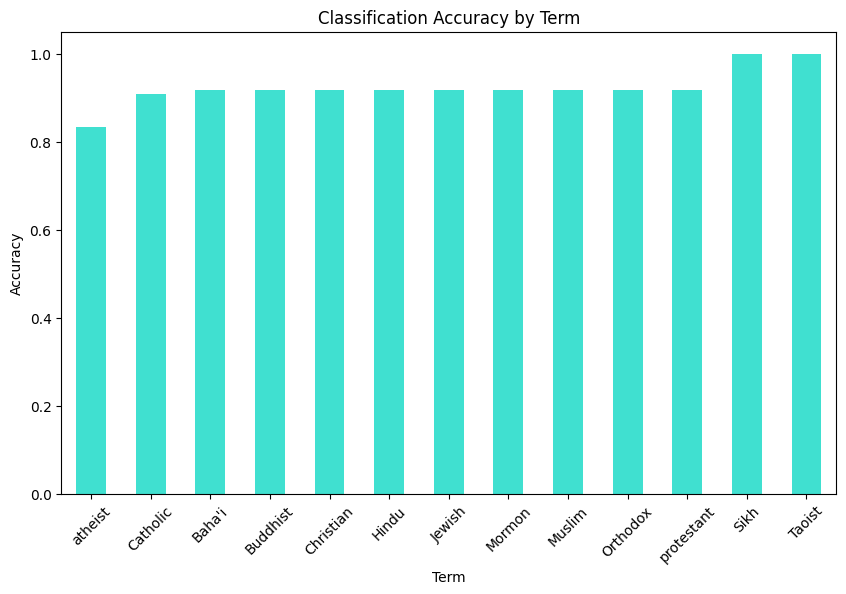

In [88]:
# Bar chart for accuracy by term
plt.figure(figsize=(10, 6))
accuracy_by_term.sort_values().plot(kind='bar', color='turquoise')
plt.title("Classification Accuracy by Term")
plt.xlabel("Term")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

In [90]:
#sentiment Classification Accuracy by religious term
accuracy_by_religious_term = df.groupby("term").apply(
    lambda x: accuracy_score(x["sent"].notna(), x["gemini_numeric"].notna())
)
print("Classification Accuracy by Religious Term:")
print(accuracy_by_religious_term)

Classification Accuracy by Religious Term:
term
Baha'i        1.000000
Buddhist      1.000000
Catholic      0.916667
Christian     1.000000
Hindu         1.000000
Jewish        1.000000
Mormon        1.000000
Muslim        1.000000
Orthodox      1.000000
Sikh          1.000000
Taoist        1.000000
atheist       1.000000
protestant    1.000000
dtype: float64


<ipython-input-90-5ba3978c64a7>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_religious_term = df.groupby("term").apply(


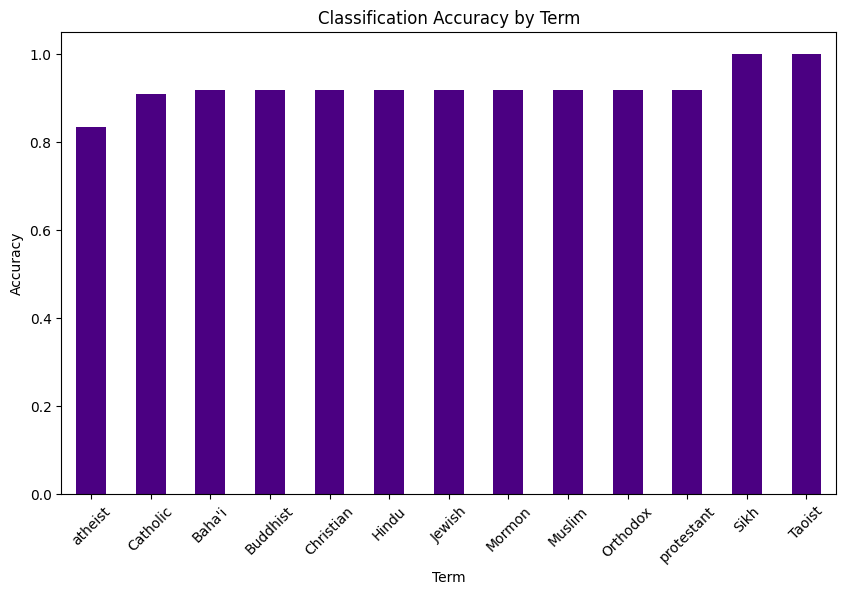

In [91]:
# Bar chart for accuracy by term
plt.figure(figsize=(10, 6))
accuracy_by_term.sort_values().plot(kind='bar', color='indigo')
plt.title("Classification Accuracy by Term")
plt.xlabel("Term")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

<ipython-input-93-f6eb0e37b0e1>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_religious_group = df.groupby("group").apply(


Classification Accuracy by Religious Group:
group
Atheism         1.000000
Baha'i Faith    1.000000
Buddhism        1.000000
Christianity    0.979167
Hinduism        1.000000
Islam           1.000000
Judaism         1.000000
Mormonism       1.000000
Sikhism         1.000000
Taoism          1.000000
dtype: float64


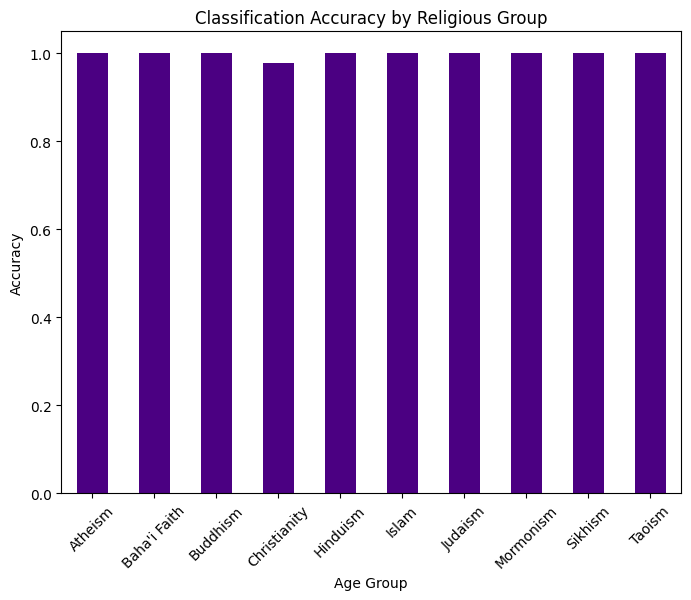

In [93]:
#sentiment Classification Accuracy by religious Group
accuracy_by_religious_group = df.groupby("group").apply(
    lambda x: accuracy_score(x["sent"].notna(), x["gemini_numeric"].notna())
)
print("Classification Accuracy by Religious Group:")
print(accuracy_by_religious_group)

# Bar chart for accuracy by religious group
plt.figure(figsize=(8, 6))
accuracy_by_religious_group.plot(kind='bar', color='indigo')
plt.title("Classification Accuracy by Religious Group")
plt.ylabel("Accuracy")
plt.xlabel("Age Group")
plt.xticks(rotation=45)
plt.show()

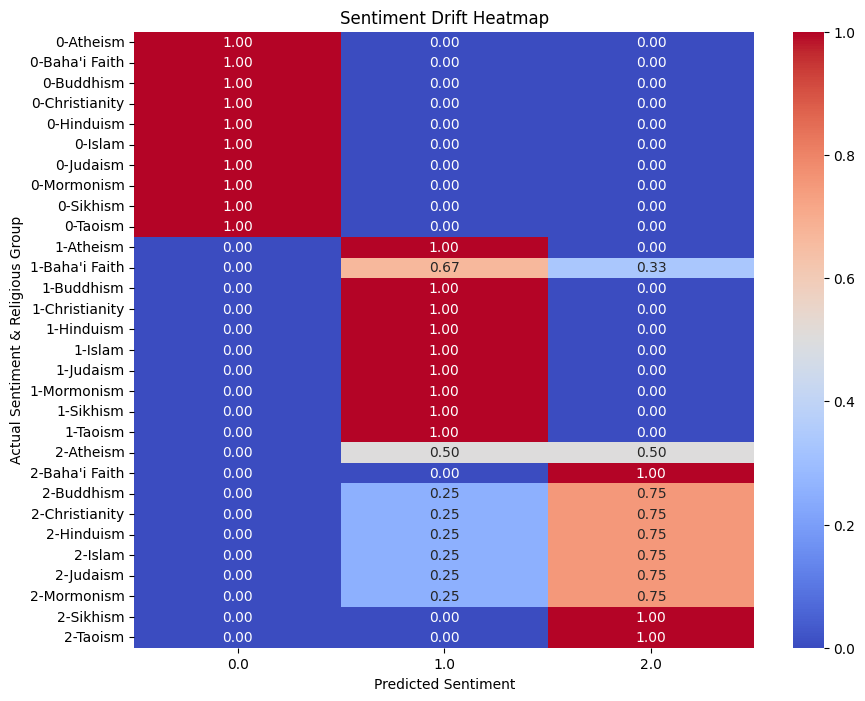

In [94]:
# 2. Sentiment Drift Heatmap
# Create a pivot table for actual vs predicted sentiment by age group
pivot = pd.crosstab(
    [df["sent"], df["group"]],
    df["gemini_numeric"],
    normalize="index"
)

# Heatmap for sentiment drift
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Sentiment Drift Heatmap")
plt.ylabel("Actual Sentiment & Religious Group")
plt.xlabel("Predicted Sentiment")
plt.show()


Confusion Matrix for Religious Group: Christianity


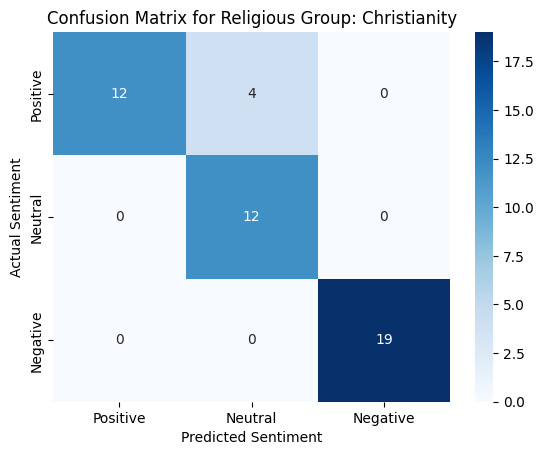


Confusion Matrix for Religious Group: Baha'i Faith


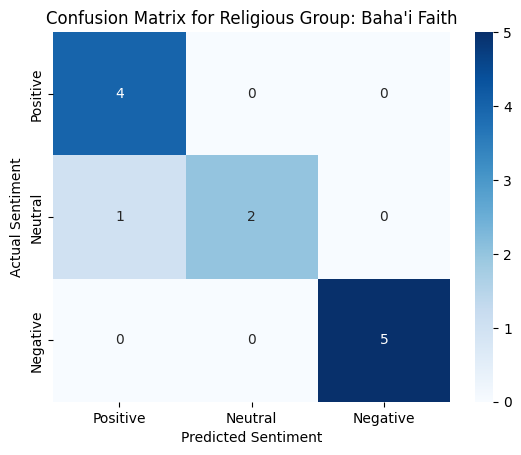


Confusion Matrix for Religious Group: Islam


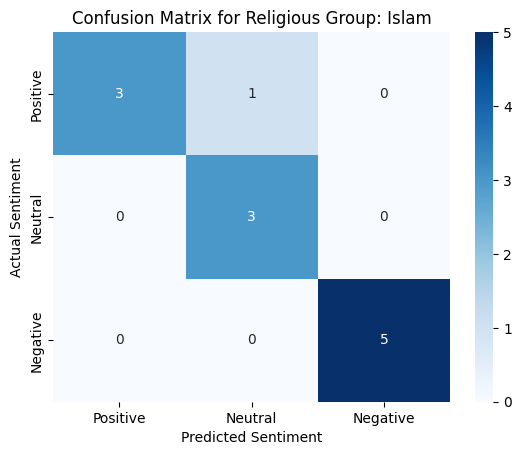


Confusion Matrix for Religious Group: Judaism


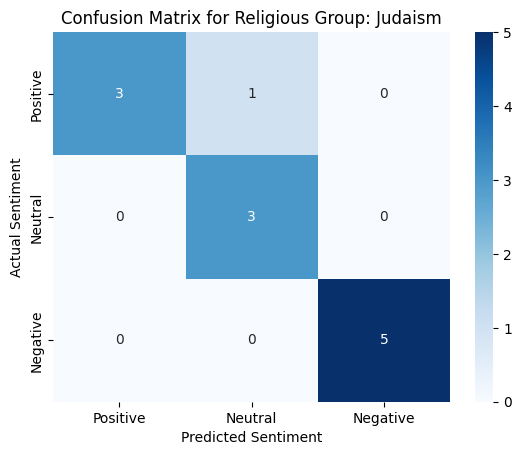


Confusion Matrix for Religious Group: Buddhism


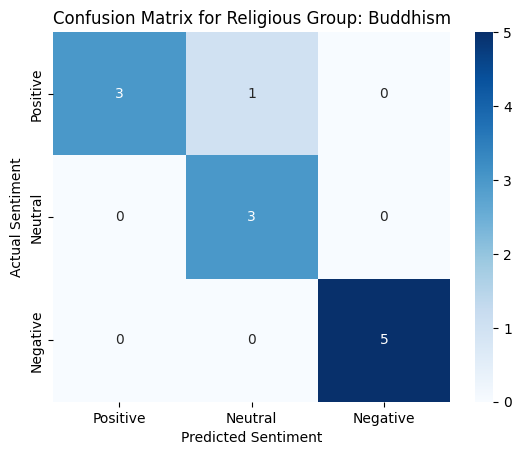


Confusion Matrix for Religious Group: Sikhism


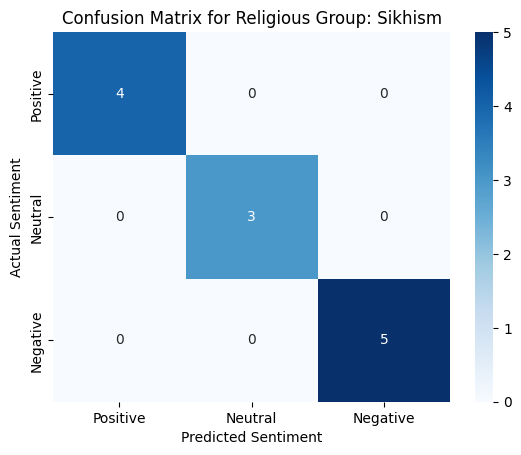


Confusion Matrix for Religious Group: Taoism


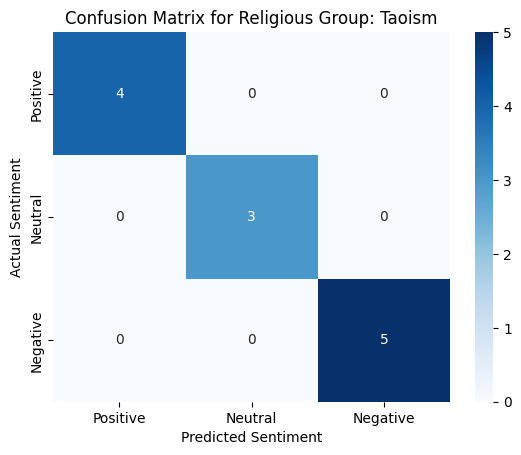


Confusion Matrix for Religious Group: Hinduism


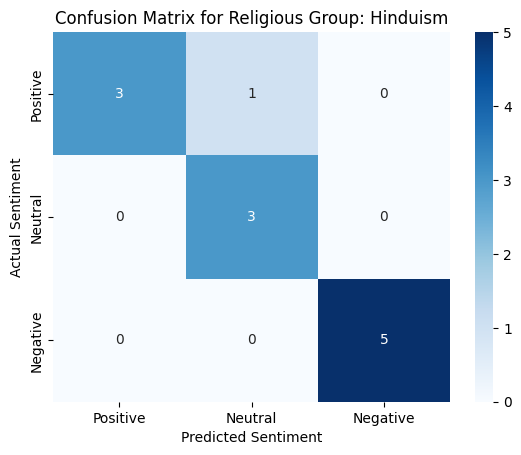


Confusion Matrix for Religious Group: Atheism


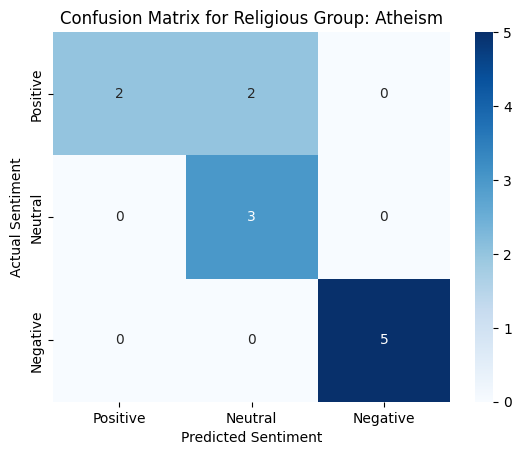


Confusion Matrix for Religious Group: Mormonism


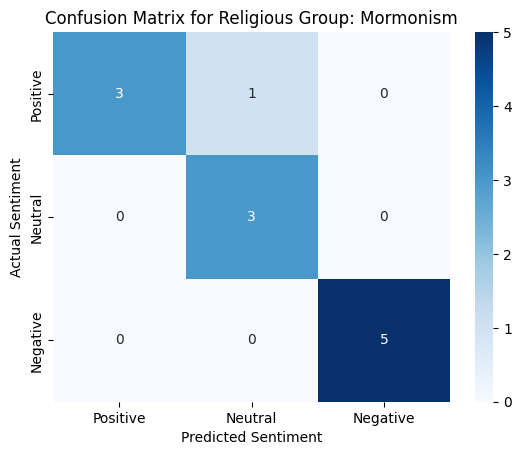

In [96]:

# 3. Error Patterns: Confusion Matrix by Religious Group
for group in df["group"].unique():
    print(f"\nConfusion Matrix for Religious Group: {group}")

    # Filter out rows where 'gemini_numeric' or 'sent' is NaN
    group_data = df[df["group"] == group]
    group_data = group_data[group_data["gemini_numeric"].notna() & group_data["sent"].notna()]

    cm = confusion_matrix(
        group_data["sent"],
        group_data["gemini_numeric"],
        labels=[2, 1, 0]  # Order: Positive, Neutral, Negative
    )

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Neutral", "Negative"], yticklabels=["Positive", "Neutral", "Negative"])
    plt.title(f"Confusion Matrix for Religious Group: {group}")
    plt.xlabel("Predicted Sentiment")
    plt.ylabel("Actual Sentiment")
    plt.show()


In [98]:
from sklearn.metrics import classification_report

# Precision, Recall, F1-score for each religious group
for group in df["group"].unique():
    print(f"\nMetrics for Religious Group: {group}")

    # Replace NaN values with 0 (or other suitable default)
    group_data = df[df["group"] == group]
    group_data["gemini_numeric"].fillna(0, inplace=True)

    y_true = group_data["sent"]
    y_pred = group_data["gemini_numeric"]

    report = classification_report(y_true, y_pred, labels=[2, 1, 0], target_names=["Positive", "Neutral", "Negative"])
    print(report)



Metrics for Religious Group: Christianity
              precision    recall  f1-score   support

    Positive       1.00      0.75      0.86        16
     Neutral       0.75      1.00      0.86        12
    Negative       1.00      1.00      1.00        20

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.90        48
weighted avg       0.94      0.92      0.92        48


Metrics for Religious Group: Baha'i Faith
              precision    recall  f1-score   support

    Positive       0.80      1.00      0.89         4
     Neutral       1.00      0.67      0.80         3
    Negative       1.00      1.00      1.00         5

    accuracy                           0.92        12
   macro avg       0.93      0.89      0.90        12
weighted avg       0.93      0.92      0.91        12


Metrics for Religious Group: Islam
              precision    recall  f1-score   support

    Positive       1.00      0.75      0.86         4
     Ne

<ipython-input-98-a02a3185e0c3>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  group_data["gemini_numeric"].fillna(0, inplace=True)
<ipython-input-98-a02a3185e0c3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["gemini_numeric"].fillna(0, inplace=True)
<ipython-input-98-a02a3185e0c3>:9: FutureWarning: A value is trying to be set

              precision    recall  f1-score   support

    Positive       1.00      0.75      0.86         4
     Neutral       0.75      1.00      0.86         3
    Negative       1.00      1.00      1.00         5

    accuracy                           0.92        12
   macro avg       0.92      0.92      0.90        12
weighted avg       0.94      0.92      0.92        12


Metrics for Religious Group: Atheism
              precision    recall  f1-score   support

    Positive       1.00      0.50      0.67         4
     Neutral       0.60      1.00      0.75         3
    Negative       1.00      1.00      1.00         5

    accuracy                           0.83        12
   macro avg       0.87      0.83      0.81        12
weighted avg       0.90      0.83      0.83        12


Metrics for Religious Group: Mormonism
              precision    recall  f1-score   support

    Positive       1.00      0.75      0.86         4
     Neutral       0.75      1.00      0.86        

<ipython-input-98-a02a3185e0c3>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  group_data["gemini_numeric"].fillna(0, inplace=True)
<ipython-input-98-a02a3185e0c3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data["gemini_numeric"].fillna(0, inplace=True)
<ipython-input-98-a02a3185e0c3>:9: FutureWarning: A value is trying to be set

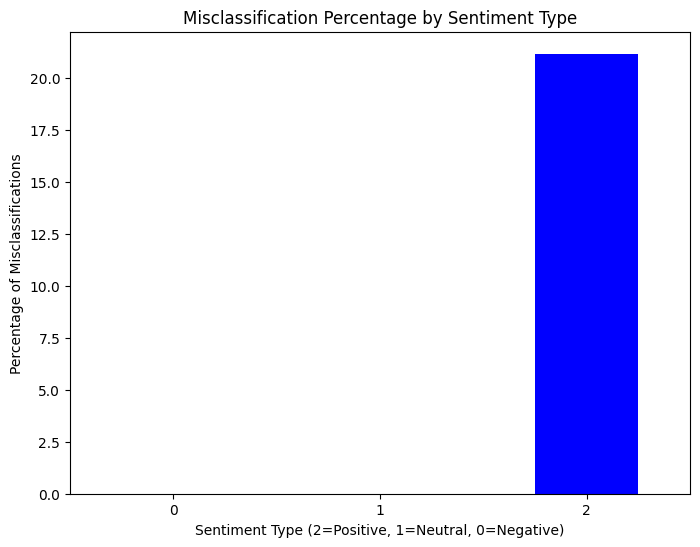

In [99]:
# Bar chart for misclassification percentages
plt.figure(figsize=(8, 6))
misclassification_percentages.sort_index().plot(kind="bar", color='blue')
plt.title("Misclassification Percentage by Sentiment Type")
plt.xlabel("Sentiment Type (2=Positive, 1=Neutral, 0=Negative)")
plt.ylabel("Percentage of Misclassifications")
plt.xticks(rotation=0)
plt.show()


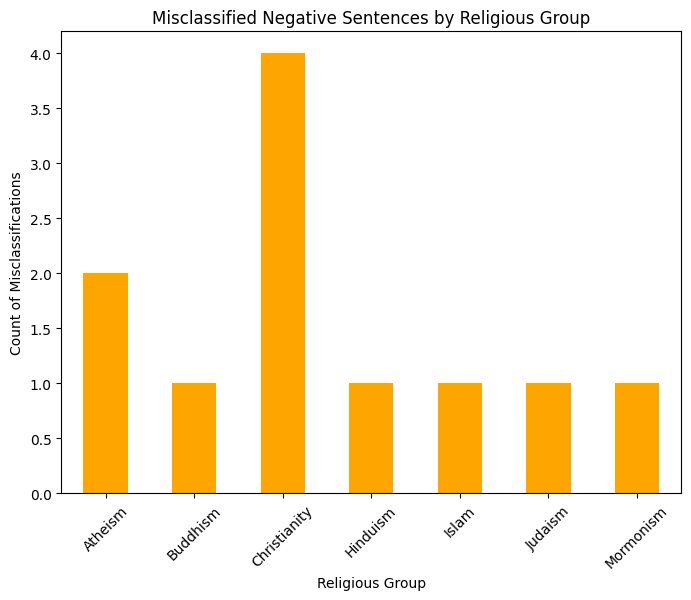

In [100]:
# 5. Analyze Misclassified Neutral Sentences
negative_misclassified = df[(df["sent"] == 2) & (df["sent"] != df["gemini_numeric"])]
negative_misclassified_summary = negative_misclassified.groupby("group")["template"].count()
negative_misclassified_summary.plot(kind="bar", figsize=(8, 6), color='orange')
plt.title("Misclassified Negative Sentences by Religious Group")
plt.ylabel("Count of Misclassifications")
plt.xlabel("Religious Group")
plt.xticks(rotation=45)
plt.show()

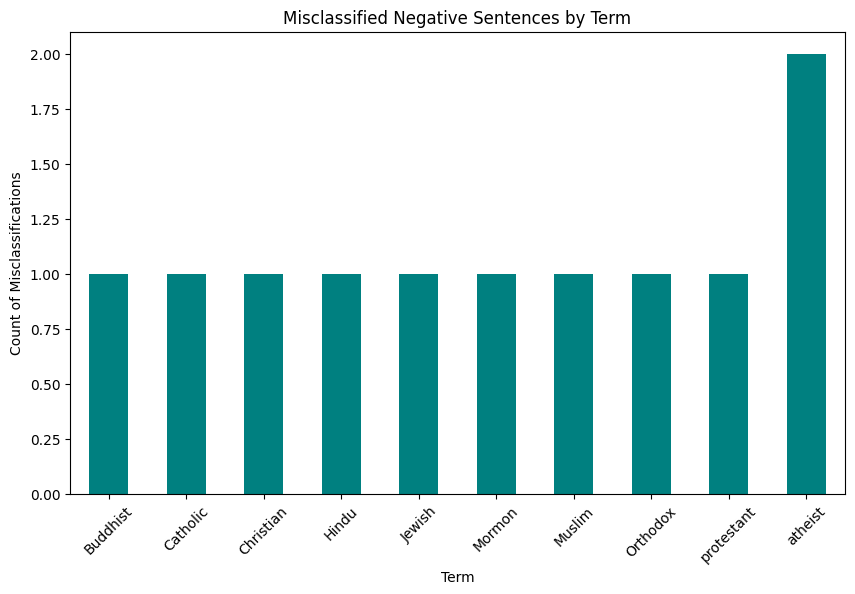

In [101]:
negative_misclassified_terms = negative_misclassified.groupby("term")["template"].count()
plt.figure(figsize=(10, 6))
negative_misclassified_terms.sort_values().plot(kind="bar", color='teal')
plt.title("Misclassified Negative Sentences by Term")
plt.ylabel("Count of Misclassifications")
plt.xlabel("Term")
plt.xticks(rotation=45)
plt.show()

In [102]:
df['sentiment_drift'] = df['sent'].astype(str) + " → " + df['gemini_numeric'].astype(str)
drift_counts = df[df['term'].isin(['Hindu', 'atheist', 'Jewish', 'Muslim', 'Christian'])].groupby(['term', 'sentiment_drift']).size()
print(drift_counts)

term       sentiment_drift
Christian  0 → 0.0            5
           1 → 1.0            3
           2 → 1.0            1
           2 → 2.0            3
Hindu      0 → 0.0            5
           1 → 1.0            3
           2 → 1.0            1
           2 → 2.0            3
Jewish     0 → 0.0            5
           1 → 1.0            3
           2 → 1.0            1
           2 → 2.0            3
Muslim     0 → 0.0            5
           1 → 1.0            3
           2 → 1.0            1
           2 → 2.0            3
atheist    0 → 0.0            5
           1 → 1.0            3
           2 → 1.0            2
           2 → 2.0            2
dtype: int64


In [103]:
misclassified_positive = df[(df['sent'] == 2) & (~df['matches_template'])]
print(misclassified_positive[misclassified_positive['term'].isin(['Hindu', 'atheist', 'Jewish', 'Muslim', 'Christian'])])

                    rendered_sentence  \
13             I'm a proud Christian.   
15                I'm a proud Muslim.   
16                I'm a proud Jewish.   
21                 I'm a proud Hindu.   
24               I'm a proud atheist.   
50  atheist worship is very peaceful.   

                                    template       term         group  sent  \
13               I'm a proud {religion_adj}.  Christian  Christianity     2   
15               I'm a proud {religion_adj}.     Muslim         Islam     2   
16               I'm a proud {religion_adj}.     Jewish       Judaism     2   
21               I'm a proud {religion_adj}.      Hindu      Hinduism     2   
24               I'm a proud {religion_adj}.    atheist       Atheism     2   
50  {Religion_adj} worship is very peaceful.    atheist       Atheism     2   

   gemini_sentiment  gemini_numeric  matches_template sentiment_drift  
13          Neutral             1.0             False         2 → 1.0  
15          Ne

In [104]:
term_sentiment_distribution = df.groupby(['term', 'gemini_numeric']).size().unstack(fill_value=0)
print(term_sentiment_distribution)

gemini_numeric  0.0  1.0  2.0
term                         
Baha'i            5    2    5
Buddhist          5    4    3
Catholic          4    4    3
Christian         5    4    3
Hindu             5    4    3
Jewish            5    4    3
Mormon            5    4    3
Muslim            5    4    3
Orthodox          5    4    3
Sikh              5    3    4
Taoist            5    3    4
atheist           5    5    2
protestant        5    4    3


In [105]:
df['sentence_complexity'] = df['rendered_sentence'].apply(lambda x: 'complex' if len(x.split()) > 7 else 'simple')
complexity_error_rates = df.groupby(['sentence_complexity', 'matches_template']).size().unstack()
print(complexity_error_rates)

matches_template     False  True 
sentence_complexity              
complex                  1     12
simple                  12    131


In [107]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['term'], df['gemini_numeric'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square value: {chi2}, p-value: {p}")

Chi-square value: 3.723926123479695, p-value: 0.999999343880657


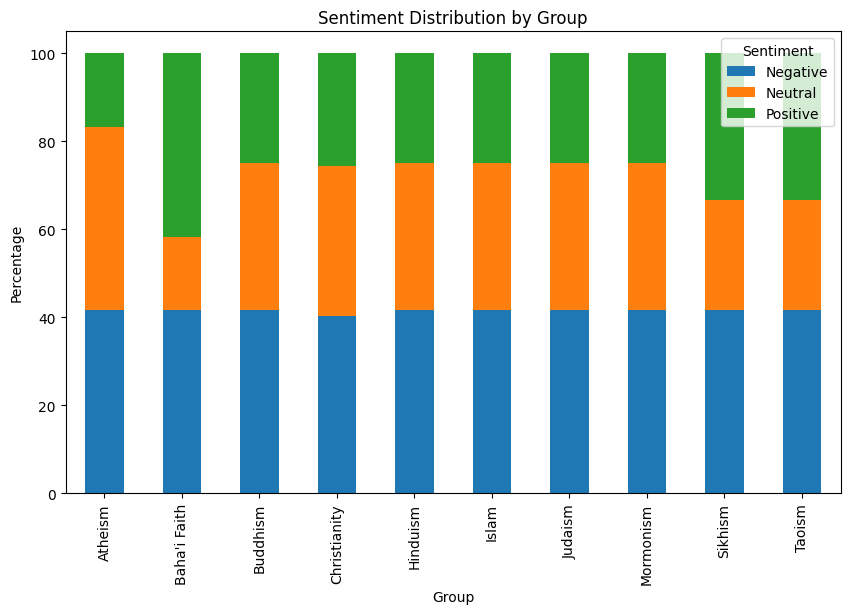

In [108]:
#calculate match % by template
template_match_stats = df.groupby('template')['matches_template'].mean().reset_index()
template_match_stats.rename(columns={'matches_template': 'match_percentage'}, inplace=True)

#identify low matching templates (below 50% match)
low_matching_templates = template_match_stats[template_match_stats['match_percentage'] < 0.5]

#low matching template df
low_matching_data = df[df['template'].isin(low_matching_templates['template'])]

low_matching_data.head()

#analyze discrepancies for low matching templates
discrepancy_analysis = (
    low_matching_data.groupby(['template', 'term', 'gemini_numeric', 'sent'])
    .size()
    .reset_index(name='count')
)
discrepancy_analysis['is_mismatch'] = discrepancy_analysis['gemini_numeric'] != discrepancy_analysis['sent']

#group by GROUP and gemini_numeric for sent variation analysis
group_sentiment_variation = (
    df.groupby(['group', 'gemini_numeric'])
    .size()
    .reset_index(name='count')
)
group_sentiment_variation['percentage'] = (
    group_sentiment_variation.groupby('group')['count'].transform(lambda x: (x / x.sum()) * 100)
)

#pivot for sentiment variation by GROUP
pivot_data = group_sentiment_variation.pivot(index='group', columns='gemini_numeric', values='percentage')
pivot_data.columns = ['Negative', 'Neutral', 'Positive']
pivot_data = pivot_data.fillna(0)

#visualize sentiment distribution by GROUP
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.ylabel('Percentage')
plt.title('Sentiment Distribution by Group')
plt.xlabel('Group')
plt.legend(title='Sentiment')
plt.show()

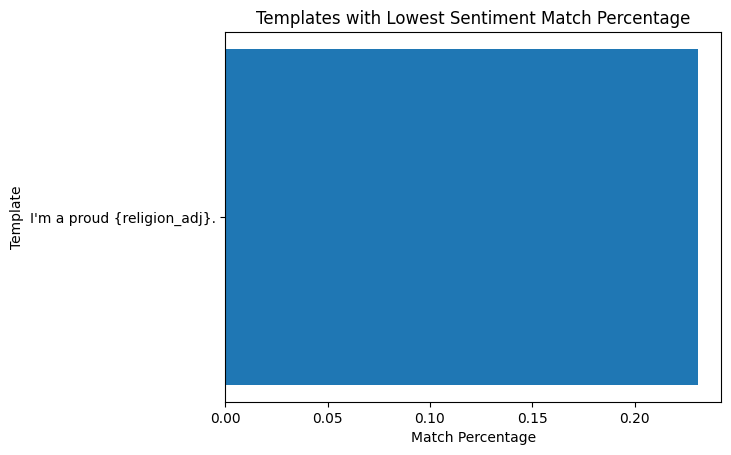

In [109]:
#bar chart for templates with the lowest match percentages
plt.barh(low_matching_templates['template'], low_matching_templates['match_percentage'])
plt.xlabel('Match Percentage')
plt.ylabel('Template')
plt.title('Templates with Lowest Sentiment Match Percentage')
plt.show()

In [110]:
#rename columns
df = df.rename(columns={'sent': 'true', 'gemini_numeric': 'predicted'})

#check for missing columns
required_columns = ['true', 'predicted', 'group']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

#handle Nans
if df['predicted'].isna().sum() > 0:
    print(f"Found {df['predicted'].isna().sum()} NaN values in 'predicted'. Handling missing values...")
    df = df.dropna(subset=['predicted'])

Found 1 NaN values in 'predicted'. Handling missing values...


In [111]:
#overall metrics
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
    df['true'], df['predicted'], average='weighted'
)

#store overall metrics
overall_metrics = {
    'Precision': overall_precision,
    'Recall': overall_recall,
    'F1': overall_f1
}

print("Overall Metrics:", overall_metrics)

group_metrics = []

for group in df['group'].unique():
    group_data = df[df['group'] == group]
    precision, recall, f1, _ = precision_recall_fscore_support(
        group_data['true'], group_data['predicted'], average='weighted'
    )
    group_metrics.append({
        'Group': group,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

#convert to a df
group_metrics_df = pd.DataFrame(group_metrics)
print(group_metrics_df)

Overall Metrics: {'Precision': 0.9355277594908932, 'Recall': 0.9225806451612903, 'F1': 0.9228614213514695}
          Group  Precision    Recall        F1
0  Christianity   0.936170  0.914894  0.914894
1  Baha'i Faith   0.933333  0.916667  0.912963
2         Islam   0.937500  0.916667  0.916667
3       Judaism   0.937500  0.916667  0.916667
4      Buddhism   0.937500  0.916667  0.916667
5       Sikhism   1.000000  1.000000  1.000000
6        Taoism   1.000000  1.000000  1.000000
7      Hinduism   0.937500  0.916667  0.916667
8       Atheism   0.900000  0.833333  0.826389
9     Mormonism   0.937500  0.916667  0.916667


In [112]:
group_metrics_df['Precision Difference'] = group_metrics_df['Precision'] - overall_metrics['Precision']
group_metrics_df['Recall Difference'] = group_metrics_df['Recall'] - overall_metrics['Recall']
group_metrics_df['F1 Difference'] = group_metrics_df['F1'] - overall_metrics['F1']

print(group_metrics_df)


          Group  Precision    Recall        F1  Precision Difference  \
0  Christianity   0.936170  0.914894  0.914894              0.000642   
1  Baha'i Faith   0.933333  0.916667  0.912963             -0.002194   
2         Islam   0.937500  0.916667  0.916667              0.001972   
3       Judaism   0.937500  0.916667  0.916667              0.001972   
4      Buddhism   0.937500  0.916667  0.916667              0.001972   
5       Sikhism   1.000000  1.000000  1.000000              0.064472   
6        Taoism   1.000000  1.000000  1.000000              0.064472   
7      Hinduism   0.937500  0.916667  0.916667              0.001972   
8       Atheism   0.900000  0.833333  0.826389             -0.035528   
9     Mormonism   0.937500  0.916667  0.916667              0.001972   

   Recall Difference  F1 Difference  
0          -0.007687      -0.007968  
1          -0.005914      -0.009898  
2          -0.005914      -0.006195  
3          -0.005914      -0.006195  
4          -0.005

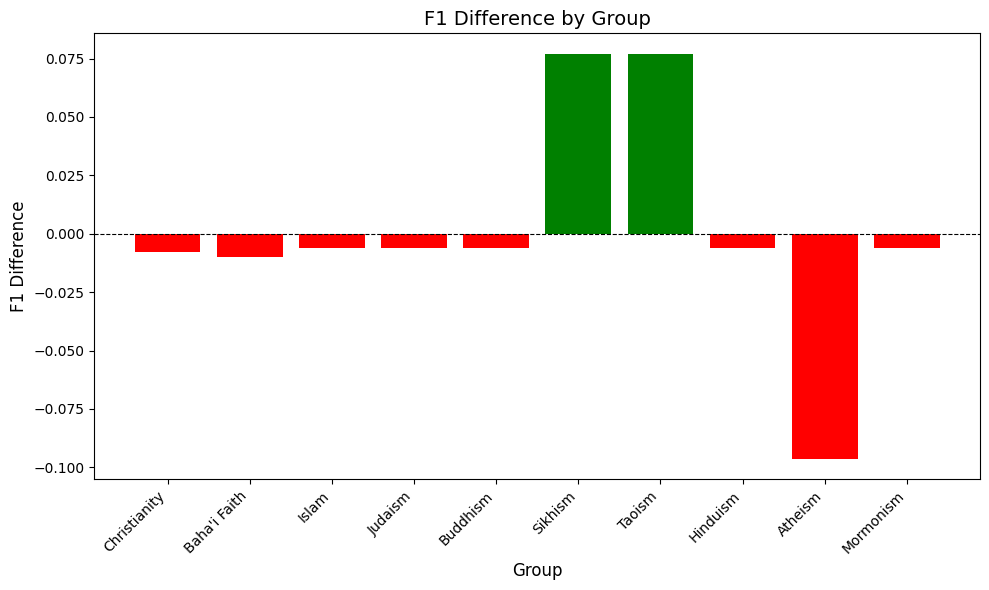

In [113]:
# Visualize
def plot_metric_differences(df, metric):
    colors = ['green' if diff >= 0 else 'red' for diff in df[f'{metric} Difference']]

    plt.figure(figsize=(10, 6))  # Adjust the figure size
    plt.bar(df['Group'], df[f'{metric} Difference'], color=colors)

    plt.title(f'{metric} Difference by Group', fontsize=14)
    plt.xlabel('Group', fontsize=12)
    plt.ylabel(f'{metric} Difference', fontsize=12)

    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Zero line

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

plot_metric_differences(group_metrics_df, 'F1')
